In [1]:
from tutorialQA_framework import *
from tutorial1_framework import *

device = torch.device('cuda:0')
device

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


device(type='cuda', index=0)

In [2]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

In [3]:
# now, a few additional imports and functions which can't be saved to a file

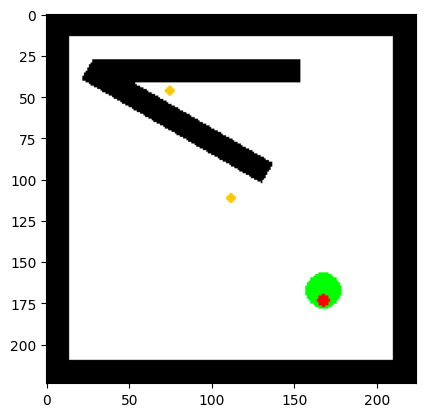

In [4]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [5]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [6]:
# Ok, now let's import the representative old and new brains

In [7]:
old_brain = DefaultAgentBrain()
old_brain.to(device)
old_brain.load_state_dict(torch.load('brain_checkpoints/brain_weights_tutorialQA_v3_batch6100.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [8]:
brain = EnhancedAgentBrain()
brain.to(device)

brain.load_state_dict(torch.load('brain_checkpoints/enhanced_brain_transferred_weights_tutorialQA.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [9]:
type(old_brain) is EnhancedAgentBrain

False

In [10]:
arrow_task_batch(64, old_brain)

/home/atbolsh/anaconda3/envs/llava-florence/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Total loss: 0.0024741371162235737; that's 0.0011276726145297289 task and 0.0006101495237089694 recon and 3.681575298309326 total text




(0.0024741371162235737,
 0.0011276726145297289,
 0.0006101495237089694,
 0.8233779668807983,
 2.8581972122192383)

In [11]:
inp, out, task_texts = task1_img_sample(2)

In [12]:
task_probs, task_recon = old_brain(task_texts, inp, ret_imgs=True)

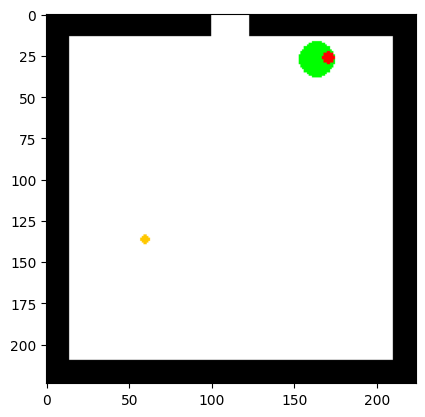

In [13]:
quick_display(inp[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35245657..1.1632477].


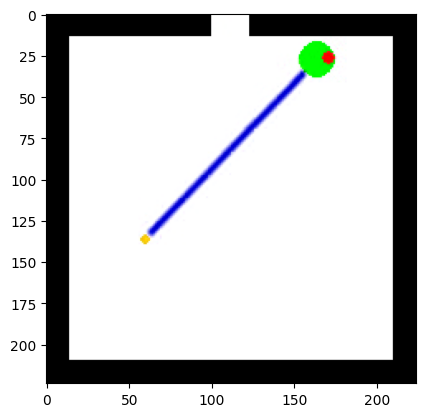

In [14]:
quick_display(task_recon[0])

In [15]:
# ok, good enough for the old brain

In [16]:
arrow_task_batch(64, brain)

Total loss: 2.5376009941101074; that's 1.2711650133132935 task and 1.2627253532409668 recon and 18.5541934967041 total text




(2.5376009941101074,
 1.2711650133132935,
 1.2627253532409668,
 9.231515884399414,
 9.322677612304688)

In [17]:
qa_task_batch(8, old_brain)

Total loss: 3.770245313644409:
2.533669948577881 control,
0.34306591749191284 lrg,
0.35008588433265686 udg,
0.285831093788147 lra,
0.2575923502445221 uda




(3.770245313644409,
 2.533669948577881,
 0.34306591749191284,
 0.35008588433265686,
 0.285831093788147,
 0.2575923502445221)

In [18]:
brain.reset()
qa_task_batch(8, brain)

Total loss: 46.4796028137207:
9.336052894592285 control,
9.212367057800293 lrg,
9.325176239013672 udg,
9.294875144958496 lra,
9.31113052368164 uda




(46.4796028137207,
 9.336052894592285,
 9.212367057800293,
 9.325176239013672,
 9.294875144958496,
 9.31113052368164)